<a href="https://colab.research.google.com/github/philmacedo/topicos-uerj/blob/main/%5BUERJ%5D_Trabalho_T%C3%B3picos_A_Philipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TRABALHO TÓPICOS A**


>**1. Objetivo**

O problema escolhido para este projeto consiste na classificação de diferentes tipos de carros com base em imagens. A identificação automatizada de veículos tem aplicações práticas em monitoramento urbano, controle de tráfego e gestão de frotas. A razão para a escolha dessa tarefa é de utilizar os conhecimentos de aprendizado de máquina com alguma técnica de otimização para que seja possível a máquina classificar os carros.

O objetivo foi identificar o tipo de carro (por exemplo, Sedan, SUV, Pickup e entre outros) a partir de uma imagem, utilizando um modelo pré-treinado como extrator de características e otimizar seus hiperparâmetros com algum algoritmo de otimização.


>**2.Premissas**

O dataset escolhido foi o "tanganke/stanford_cars" que é um dataset que contém imagens de carros de variádos modelos e tipos. Além disso, o modelo escolhido foi o "SriramSridhar78/sriram-car-classifier", que é treinado para identificar a imagem dos carros e classificá-los conforme o modelo.

Ao testar a modelagem, foi verificado que a acurácia de validação encontrada foi de **77.17%**.

A técnica de Inteligência Computacional escolhida para solução do problema foi a técnica de otimização por enxame de partículas (PSO - Particle Swarm Optimization) que consiste em um algoritmo evolutivo inspirado no comportamento coletivo de grupos como bandos de pássaros ou cardumes de peixes. Cada possível solução é chamada de partícula e essas partículas são ajustadas com base em experiências próprias e na experiência da população.

O motivo da escolha do PSO se dá pela eficiência em espaços de busca contínuos e a convergência rápida para soluções aceitáveis. Além disso, por utilizar um modelo pré-treinado de rede neural e querer refinar um parâmetros de forma eficiente, como a taxa de aprendizado, o PSO se torna adequado para o problema.

O código foi desenvolvido e testado no VsCode pela quantidade de recursos computacionais que estavam sendo utilizados. Uma observação importante é que a execução o código está levando algo aproximado de 3 horas com o uso da paralelização na GPU.




>**3. Codificação**

Com o modelo já escolhido e com a acurácia validada, foi dado o início ao processo de codificação da nova modelagem.

* Pré-processamento e pré-carregamento

Para a criação do novo modelo utilizando o modelo pré-treinado escolhido, foi necessário fazer uma readaptação na captura dos dados do dataset.

Foi observado que os rótulos do dataset era uma string composta pelo nome + modelo + tipo + ano do carro da imagem. Porém, algumas imagens não estavam com o tipo do carro em seus rótulos, portanto, para resolver o problema foi criado um dicionário *id_to_name* que a partir do id da imagem pega todo o rótulo dela, também foi verificado quais os tipos de carro que estavam presente no dataset, e com isso, foi criado uma lista contendo os tipos do carro que seriam identificados. Logo, o dataset original que tem 196 classes, passa a ter 15 classes.

Além disso, foi feito um mapeamento no dataset por meio da função *def extrair_tipo_carro* que converte as classes de modelo para tipos do carro conforme a lista que foi criada com os nomes dos tipos de carros.

Para a execução do projeto, o dataset foi limitado para usar apenas 30% das amostras nos subconjuntos de treino e validação que dá aproximadamente 2400 amostras, pois o dataset original contém 8000 amostras e estavam levando muito tempo para executar. Para uma boa aprendizagem da máquina, houve um redimensionamento nas imagens para 224x224, normalização e conversão para tensores.


O código utilizado para esta estapa se encontra abaixo.


In [ ]:
# 1. Carregamento e Preprocessamento
#=============================================

# Carregar dataset Stanford Cars com cache
dataset = load_dataset("tanganke/stanford_cars")


# Obter lista de nomes das classes
label_names = dataset["train"].features["label"].names

# Dicionário índice -> nome completo do carro
id_to_name = {i: name for i, name in enumerate(label_names)}

# Lista dos tipos que queremos identificar
tipos_carro = [
    'Sedan', 'SUV', 'Coupe', 'Convertible', 'Hatchback',
    'Wagon', 'Minivan', 'Van', 'Crew Cab', 'Extended Cab',
    'Regular Cab', 'Roadster', 'Cargo Van', 'Pickup'
]

# Fixar a semente para reprodução
random.seed(42)

# Frações desejadas (exemplo: 30% dos dados)
frac_train = 0.3
frac_test = 0.3

train_subset = dataset["train"].select(random.sample(range(len(dataset["train"])), int(len(dataset["train"]) * frac_train)))
test_subset = dataset["train"].select(random.sample(range(len(dataset["train"])), int(len(dataset["train"]) * frac_train)))


# Função para extrair tipo do nome completo
def extrair_tipo_carro(nome_completo):
    for tipo in tipos_carro:
        if tipo in nome_completo:
            return tipo
    return 'Outro'

# Dicionário índice -> tipo do carro
id_to_type = {idx: extrair_tipo_carro(name) for idx, name in id_to_name.items()}

# Transformações para as imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

class CarsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset  # apenas referência, sem carregar tudo
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]
        tipo = id_to_type[label]
        if self.transform:
            image = self.transform(image)
        return image, label, tipo

# Datasets transformados
train_data = CarsDataset(train_subset, transform=transform)
val_data = CarsDataset(test_subset, transform=transform)


# DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=128, num_workers=0, pin_memory=True)


* Modelo

O modelo pré-treinado já havia sido treinado anteriormente em imagens de carros, o que permite reutilizar o conhecimento. Logo, a estratégia foi congelar todas as camadas convolucionais e modificar e treinar a última camada de classificação para o novo conjunto de tipos de carro.

O código foi feito de maneira que define de forma eficiente carregar o modelo pré-treinado apenas uma vez na memória por meio da variável *modelo_base* e depois cria cópias independentes desse modelo para uso paralelo na GPU em diferentes partículas do PSO, sem haver interferência entre elas e otimizando assim o tempo de execução.

A função *carregar_modelo* retorna um modelo pronto para ser clonado posteriormente, com pesos já carregados na memória.

A função *clonar_modelo* carrega o modelo base, extrai a configuração da arquitetura do modelo, cria uma nova instância do modelo sem os pesos, copia todos os pesos do modelo base para o novo modelo, coloca a nova instância na GPU. Cada chamada dessa função retorna uma nova cópia do modelo com os mesmos pesos iniciais, porém independentes, permitindo para que o treinamento ocorra separadamente por cada partícula do PSO.

O código dessa etapa da modelagem se encontra abaixo.


In [ ]:
# --------------------
# Modelo - Cacheado
# --------------------
modelo_base = None  # variável global para guardar o modelo carregado

# Função que retorna uma cópia independente do modelo
def carregar_modelo():
    global modelo_base
    if modelo_base is None:
        print("Carregando modelo base...")
        modelo_base = AutoModelForImageClassification.from_pretrained("SriramSridhar78/sriram-car-classifier").to("cuda")
        for param in modelo_base.parameters():
            param.requires_grad = False
        for param in modelo_base.classifier.parameters():
            param.requires_grad = True
    return modelo_base

#Cria uma nova instância do modelo com os pesos do modelo_base,
# para usar cópias independentes no PSO.
def clonar_modelo(device):
    base = carregar_modelo()
    config = base.config  # pega a configuração do modelo já carregado
    novo_modelo = AutoModelForImageClassification.from_config(config).to(device)
    novo_modelo.load_state_dict(base.state_dict())
    for param in novo_modelo.parameters():
        param.requires_grad = False
    for param in novo_modelo.classifier.parameters():
        param.requires_grad = True
    return novo_modelo

* Otimização

A inteligência computacional utilizada no código foi o PSO e teve a função de encontrar o melhor learning rate que maximize a acurácia do novo classificador.

Para iniciar a implementação do algoritmo, foi preciso criar a função *inicializar_particulas* que recebe como parâmetros o número total de partículas que seriam criadas, qual os limites inferior/superior da posição para o learning rate e qual os limites para a velocidade de cada partícula. A inicilaização das partículas é feita de maneira aleatória para posição e velocidade. O retorno da função é uma lista de partículas no formato de dicionário com a posição, velocidade, melhor posição conhecida por ela e a acurácia já alcançada.

Em seguida, foi criada a função *avaliar_particula* que recebe o vetor de posição a partícula e os dataloaders para treino e validação. O learning rate é extraído da posição, depois é realizado uma clonagem do modelo base com os pesos iniciais, o otimizador e função perda são configurados, e por fim, o treinamento realizado em 5 épocas e ocorre a validação. A função retorna a acurácia que é a função fitness da partícula.

Foi adicionado também a função *avaliar_wrapper* que é usada com multiprocessing.Pool para mapear argumentos que será utilizado no paralelismo da GPU para acelerar a avaliação das partículas.

A função *pso* recebe o número de partículas, número de iterações e os hiperparâmetros de inércia (manter velocidade anterior), componente cognitivo(busca pessoal) e componente social (busca global). Ocorre a inicialização das partículas, depois é criado o melhor global (gbest), em seguida começa o loop das iteraçõs do PSO e a avaliação paralela das partículas, onde cada partícula tem o learning rate avaliado com o modelo clonado. Além disso, ocorre as atualizações das melhores posições e velocidade das partículas e depois a acurácia e o leraning rate são guardados em listas de histórico. A função retorna a melhor solução encontrada, o histórico com melhor acurácia de cada iteração e o histórico com o melhor learning rate de cada iteração.

O código completo do PSO se encontra abaixo.





In [ ]:
# --------------------
# PSO - Avaliação e Execução
# --------------------
def inicializar_particulas(n_particulas, limites_pos, limites_vel):
    particulas = []
    for _ in range(n_particulas):
        pos = np.array([np.random.uniform(low, high) for (low, high) in limites_pos])
        vel = np.array([np.random.uniform(low, high) for (low, high) in limites_vel])
        particulas.append({
            'pos': pos,
            'vel': vel,
            'melhor_pos': pos.copy(),
            'melhor_score': -np.inf
        })
    return particulas

def avaliar_particula(pos, train_loader, val_loader, device):
    lr = float(pos[0])

    print(f"\nAvaliando partícula - Learning Rate: {lr:.6f}")
    start_time = time.perf_counter()
    model = clonar_modelo(device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    model.train()
    for epoch in range(5):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    #validação
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acuracia = correct / total

    end_time = time.perf_counter()
    tempo = end_time - start_time

    print(f"Acurácia da partícula: {acuracia* 100:.2f}%")
    print(f"Tempo de avaliação da partícula: {tempo:.2f} segundos")
    return acuracia

def avaliar_wrapper(args):
    return avaliar_particula(*args)

def pso(n_particulas, n_iter, limites_pos, limites_vel, train_loader, val_loader, device, w=0.5, c1=1.5, c2=1.5):
    particulas = inicializar_particulas(n_particulas, limites_pos, limites_vel)
    gbest = {'pos': None, 'score': -np.inf}
    historico_scores = []
    historico_params = []


    for it in range(n_iter):
        #avalia as partículas em paralelo
        with Pool(processes=2) as pool:
            resultados = pool.map(avaliar_wrapper, [
                (p['pos'], train_loader, val_loader, device) for p in particulas
            ])
        # Atualiza o histórico de cada partícula com os resultados
        for i, score in enumerate(resultados):
            p = particulas[i]
            if score > p['melhor_score']:
                p['melhor_score'] = score
                p['melhor_pos'] = p['pos'].copy()
            if score > gbest['score']:
                gbest['score'] = score
                gbest['pos'] = p['pos'].copy()

        # Atualiza velocidades e posições
        for p in particulas:
            r1 = np.random.rand(len(p['pos']))
            r2 = np.random.rand(len(p['pos']))
            p['vel'] = (
                w * p['vel'] +
                c1 * r1 * (p['melhor_pos'] - p['pos']) +
                c2 * r2 * (gbest['pos'] - p['pos'])
            )
            p['pos'] += p['vel']
            for i, (low, high) in enumerate(limites_pos):
                p['pos'][i] = np.clip(p['pos'][i], low, high)

        historico_scores.append(gbest['score'])
        historico_params.append(gbest['pos'].copy())
        print(f"Iter {it+1}/{n_iter} - Melhor Score: {gbest['score']:.4f} - LR: {gbest['pos'][0]:.6f}")

    return gbest, historico_scores, historico_params


    def plot_historico(historico_scores, historico_params):
    iteracoes = range(1, len(historico_scores) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(iteracoes, historico_scores, 'b-', label='Melhor Score (Acurácia)')
    plt.xlabel('Iteração')
    plt.ylabel('Acurácia')
    plt.title('Histórico de Acurácia no PSO')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(iteracoes, [p[0] for p in historico_params], 'r-', label='Learning Rate')
    plt.xlabel('Iteração')
    plt.ylabel('Learning Rate')
    plt.title('Histórico do Learning Rate no PSO')
    plt.legend()
    plt.grid(True)
    plt.show()

>**4. Resultados**

Lembrando que para a execução foram utilizado apenas 30% das amostras que correspondem a aproximadamente 2400 amostras.

O algoritmo foi executado algumas vezes com mudanças na inicialização do código ou com modificações na quantidade de épocas no treinamento das partículas.

Foram feitas execuções quando a definição do limite de posição das particulas estava (1e-4, 1e-3), 5 partículas, 8 iterações e 5 épocas de treinamento e algumas acurácias encontradas nas execuções foram de **79.98% e 88.99%**.

O melhor resultado encontrado foi quando o limite de posição das partículas foi aumentado para (1e-4, 5e-3), mantido a quantidade de partículas, iterações e épocas. O resultado encontrado foi a acurácia de **92.43%**.

A figura abaixo mostra o gráfico do learning rate por iteração da execução da acurácia de **92.43%**

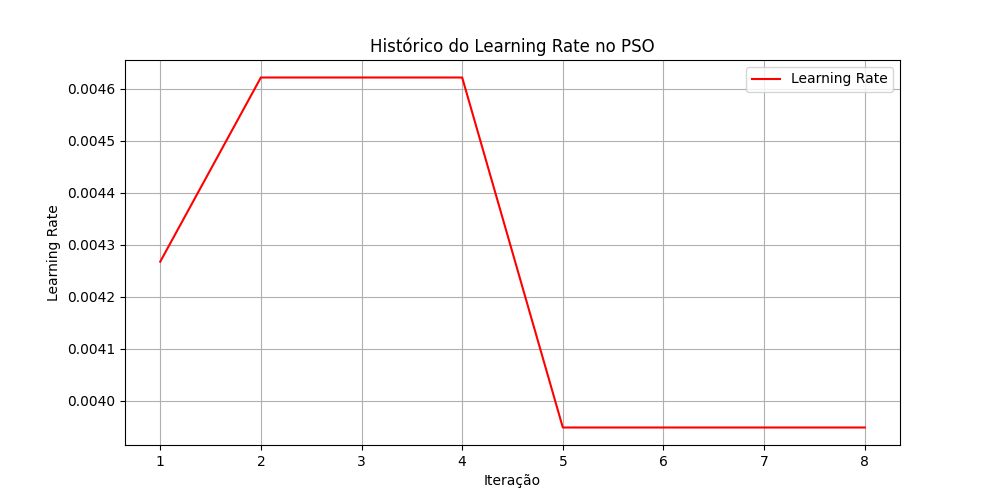

Observa-se que o learning rate começa em torno ded 0.0043 na iteração 1 e que atinge um pico em 0.0046 entre as iterações 2 a 4. Além disso, o learning rate cai para 0.003949 na iteração 5 e permanece estável até a iteração 8.

A figura abaixo mostra o gráfico da acurácia por iteração da execução da acurácia de **92.43%**.

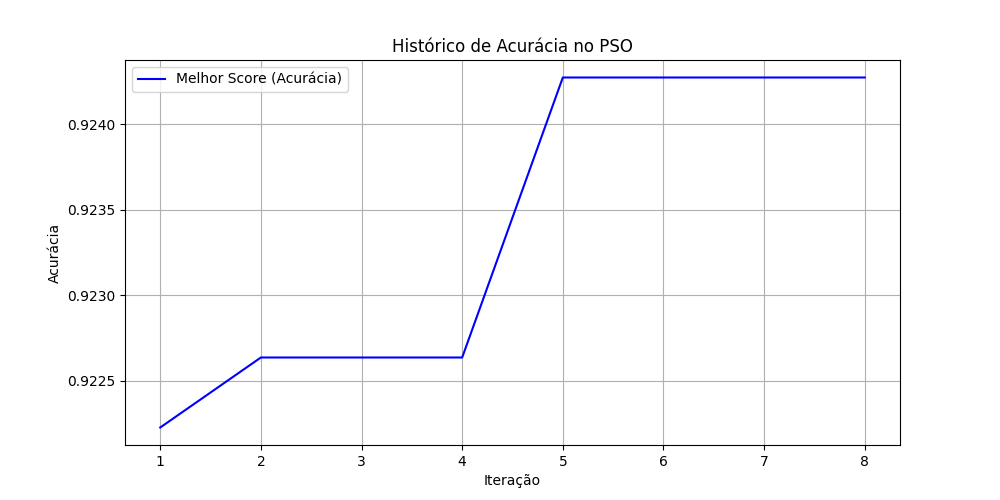

Observa-se que a acurácia melhora nas primeiras 2 iterações e depois permanece estável até a iteração 4, em seguida ocorre uma melhora na iteração 5 alcançando a melhor acurácia de 92.43% que se mantem até a iteração 8.

Ao observar o projeto, é possível identificar que foi demonstrado com sucesso a aplicação do algoritmo de PSO na otimização de um modelo de classificação de imagens, onde foi possível encontrar um bom resultado na acurácia do modelo.

Pelos gráficos plotaos, conclui-se que o algoritmo PSO foi eficiente em econtrar um ótimo learning rate dentro do intervalo definido, o comportamento de "estabilidade" a partir da iteração 5 indica que as partículas se agruparam em torno a melhor solução e que a combinação de acurácia de 92.43% com o learning rate de 0.003949 mostra que o PSO se ajustou de modo dinâmico.

Abaixo se econtra o código completo utilizado no projeto.

In [ ]:
# CÓDIGO resultado de 92.43% com 5 épocas e limites_pos = [(1e-5, 5e-3)]
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from datasets import load_dataset
from transformers import AutoImageProcessor, AutoModelForImageClassification
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from torch.multiprocessing import Pool


# 1. Carregamento e Preprocessamento
#=============================================

# Carregar dataset Stanford Cars com cache
dataset = load_dataset("tanganke/stanford_cars")


# Obter lista de nomes das classes
label_names = dataset["train"].features["label"].names

# Dicionário índice -> nome completo do carro
id_to_name = {i: name for i, name in enumerate(label_names)}

# Lista dos tipos que queremos identificar
tipos_carro = [
    'Sedan', 'SUV', 'Coupe', 'Convertible', 'Hatchback',
    'Wagon', 'Minivan', 'Van', 'Crew Cab', 'Extended Cab',
    'Regular Cab', 'Roadster', 'Cargo Van', 'Pickup'
]

# Fixar a semente para reprodução
random.seed(42)

# Frações desejadas (exemplo: 30% dos dados)
frac_train = 0.3
frac_test = 0.3

train_subset = dataset["train"].select(random.sample(range(len(dataset["train"])), int(len(dataset["train"]) * frac_train)))
test_subset = dataset["train"].select(random.sample(range(len(dataset["train"])), int(len(dataset["train"]) * frac_train)))


# Função para extrair tipo do nome completo
def extrair_tipo_carro(nome_completo):
    for tipo in tipos_carro:
        if tipo in nome_completo:
            return tipo
    return 'Outro'

# Dicionário índice -> tipo do carro
id_to_type = {idx: extrair_tipo_carro(name) for idx, name in id_to_name.items()}

# Transformações para as imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

class CarsDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset  # apenas referência, sem carregar tudo
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"].convert("RGB")
        label = item["label"]
        tipo = id_to_type[label]
        if self.transform:
            image = self.transform(image)
        return image, label, tipo

# Datasets transformados
train_data = CarsDataset(train_subset, transform=transform)
val_data = CarsDataset(test_subset, transform=transform)


# DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=128, num_workers=0, pin_memory=True)



# --------------------
# Modelo - Cacheado
# --------------------
modelo_base = None  # variável global para guardar o modelo carregado

# Função que retorna uma cópia independente do modelo
def carregar_modelo():
    global modelo_base
    if modelo_base is None:
        print("Carregando modelo base...")
        modelo_base = AutoModelForImageClassification.from_pretrained("SriramSridhar78/sriram-car-classifier").to("cuda")
        for param in modelo_base.parameters():
            param.requires_grad = False
        for param in modelo_base.classifier.parameters():
            param.requires_grad = True
    return modelo_base

#Cria uma nova instância do modelo com os pesos do modelo_base,
# para usar cópias independentes no PSO.
def clonar_modelo(device):
    base = carregar_modelo()
    config = base.config  # pega a configuração do modelo já carregado
    novo_modelo = AutoModelForImageClassification.from_config(config).to(device)
    novo_modelo.load_state_dict(base.state_dict())
    for param in novo_modelo.parameters():
        param.requires_grad = False
    for param in novo_modelo.classifier.parameters():
        param.requires_grad = True
    return novo_modelo

# --------------------
# PSO - Avaliação e Execução
# --------------------
def inicializar_particulas(n_particulas, limites_pos, limites_vel):
    particulas = []
    for _ in range(n_particulas):
        pos = np.array([np.random.uniform(low, high) for (low, high) in limites_pos])
        vel = np.array([np.random.uniform(low, high) for (low, high) in limites_vel])
        particulas.append({
            'pos': pos,
            'vel': vel,
            'melhor_pos': pos.copy(),
            'melhor_score': -np.inf
        })
    return particulas

def avaliar_particula(pos, train_loader, val_loader, device):
    lr = float(pos[0])

    print(f"\nAvaliando partícula - Learning Rate: {lr:.6f}")
    start_time = time.perf_counter()
    model = clonar_modelo(device).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    model.train()
    for epoch in range(5):
        for images, labels, _ in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()

    #validação
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acuracia = correct / total

    end_time = time.perf_counter()
    tempo = end_time - start_time

    print(f"Acurácia da partícula: {acuracia* 100:.2f}%")
    print(f"Tempo de avaliação da partícula: {tempo:.2f} segundos")
    return acuracia

def avaliar_wrapper(args):
    return avaliar_particula(*args)

def pso(n_particulas, n_iter, limites_pos, limites_vel, train_loader, val_loader, device, w=0.5, c1=1.5, c2=1.5):
    particulas = inicializar_particulas(n_particulas, limites_pos, limites_vel)
    gbest = {'pos': None, 'score': -np.inf}
    historico_scores = []
    historico_params = []


    for it in range(n_iter):
        #avalia as partículas em paralelo
        with Pool(processes=2) as pool:
            resultados = pool.map(avaliar_wrapper, [
                (p['pos'], train_loader, val_loader, device) for p in particulas
            ])
        # Atualiza o histórico de cada partícula com os resultados
        for i, score in enumerate(resultados):
            p = particulas[i]
            if score > p['melhor_score']:
                p['melhor_score'] = score
                p['melhor_pos'] = p['pos'].copy()
            if score > gbest['score']:
                gbest['score'] = score
                gbest['pos'] = p['pos'].copy()

        # Atualiza velocidades e posições
        for p in particulas:
            r1 = np.random.rand(len(p['pos']))
            r2 = np.random.rand(len(p['pos']))
            p['vel'] = (
                w * p['vel'] +
                c1 * r1 * (p['melhor_pos'] - p['pos']) +
                c2 * r2 * (gbest['pos'] - p['pos'])
            )
            p['pos'] += p['vel']
            for i, (low, high) in enumerate(limites_pos):
                p['pos'][i] = np.clip(p['pos'][i], low, high)

        historico_scores.append(gbest['score'])
        historico_params.append(gbest['pos'].copy())
        print(f"Iter {it+1}/{n_iter} - Melhor Score: {gbest['score']:.4f} - LR: {gbest['pos'][0]:.6f}")

    return gbest, historico_scores, historico_params

def plot_historico(historico_scores, historico_params):
    iteracoes = range(1, len(historico_scores) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(iteracoes, historico_scores, 'b-', label='Melhor Score (Acurácia)')
    plt.xlabel('Iteração')
    plt.ylabel('Acurácia')
    plt.title('Histórico de Acurácia no PSO')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(iteracoes, [p[0] for p in historico_params], 'r-', label='Learning Rate')
    plt.xlabel('Iteração')
    plt.ylabel('Learning Rate')
    plt.title('Histórico do Learning Rate no PSO')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == '__main__':
    from torch.multiprocessing import freeze_support
    freeze_support()

    print("Início da execução...")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")


    print("Inicializando PSO...")

    limites_pos = [(1e-5, 5e-3)]  # Apenas learning rate
    limites_vel = [(-1e-4, 1e-4)]

    melhor, historico_scores, historico_params = pso(n_particulas=5, n_iter=8, limites_pos=limites_pos, limites_vel=limites_vel,
                 train_loader=train_loader, val_loader=val_loader, device=device)

    print("Melhor solução encontrada:")
    print(f"Learning rate: {melhor['pos'][0]:.6f}, Acurácia: {melhor['score']* 100:.2f}%")

    plot_historico(historico_scores, historico_params)
